
Model Parameters:
D =  0.600, E =  0.200
Alpha =  0.200, Beta =  1.000, Gamma =  1.000
DRUG RELEASE TRACKING MODEL - PYTHON VERSION

Solving ODE system...
Spatial points: 26
Time points: 6
Total equations: 78
Solution completed.
Output shape: (6, 78)

Function calls: 1474


     t       x       u(x,t)       v(x,t)       s(x,t)
-------------------------------------------------------
   0.0  -0.50     0.75000     0.25000     0.00000
   0.0  -0.46     0.75000     0.25000     0.00000
   0.0  -0.42     0.75000     0.25000     0.00000
   0.0  -0.38     0.75000     0.25000     0.00000
   0.0  -0.34     0.75000     0.25000     0.00000
   0.0  -0.30     0.75000     0.25000     0.00000
   0.0  -0.26     0.75000     0.25000     0.00000
   0.0  -0.22     0.75000     0.25000     0.00000
   0.0  -0.18     0.75000     0.25000     0.00000
   0.0  -0.14     0.75000     0.25000     0.00000
   0.0  -0.10     0.75000     0.25000     0.00000
   0.0  -0.06     0.75000     0.25000     0.00000
   0.0  -0.02 

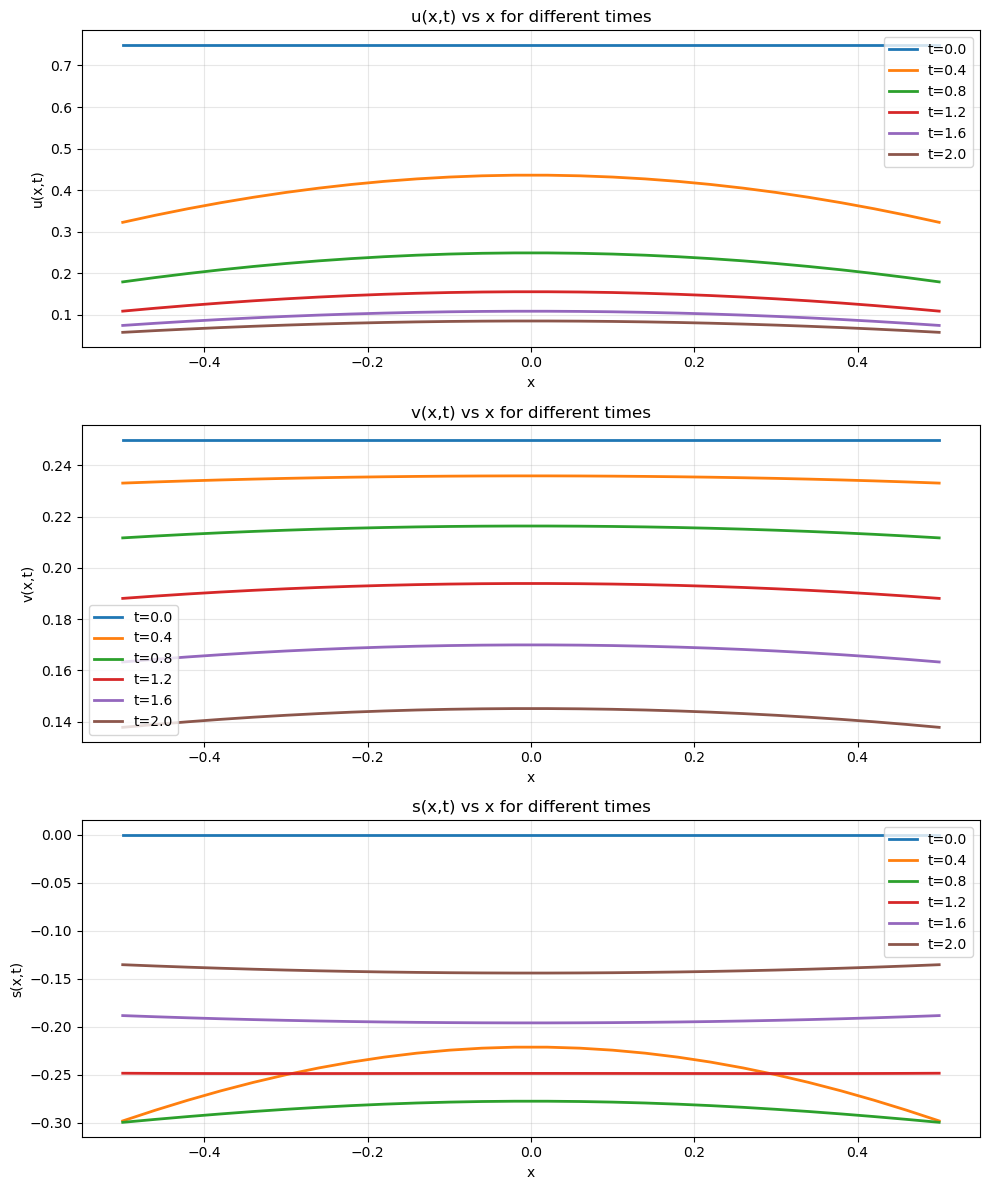


Conservation Analysis:
Initial total mass: 1.000000
Final total mass: 0.077551
Mass change: -92.2449%


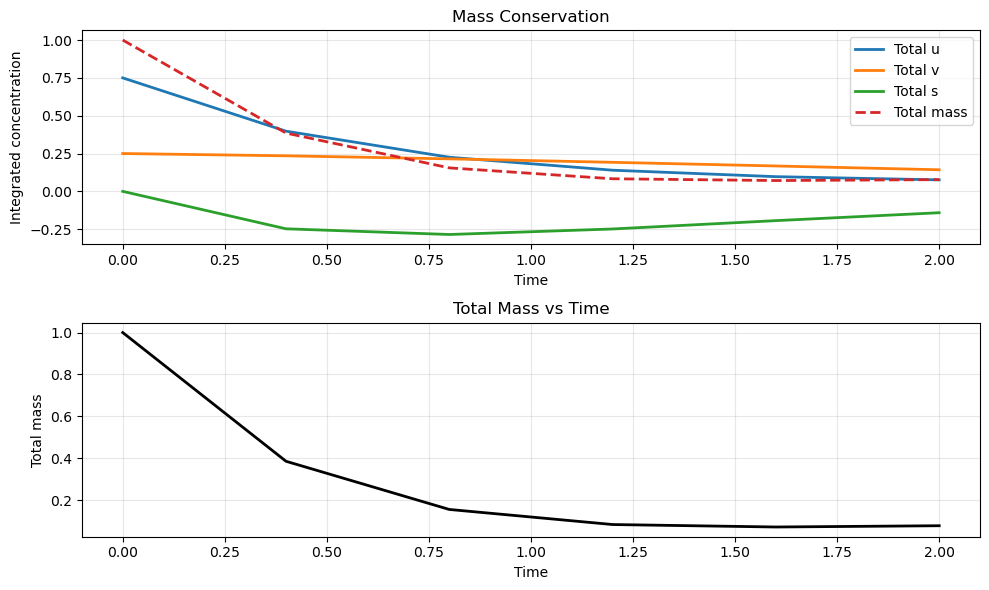


Model execution completed successfully!
Solutions available as: u_xplot, v_xplot, s_xplot


In [5]:
"""
==============================================================================
DRUG RELEASE TRACKING MODEL - PYTHON VERSION (FIXED)
Three-PDE System for Drug Release Dynamics
==============================================================================
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import os
import sys

# ==============================================================================
# HELPER FUNCTIONS (Python equivalents of R functions)
# ==============================================================================

def dss004(xl, xu, n, u):
    """
    Fourth-order finite difference approximation for first derivative
    Equivalent to R's dss004 function
    """
    dx = (xu - xl) / (n - 1)
    ux = np.zeros(n)
    
    # Interior points (4th order central difference)
    for i in range(2, n-2):
        ux[i] = (-u[i+2] + 8*u[i+1] - 8*u[i-1] + u[i-2]) / (12*dx)
    
    # Boundary points (forward/backward differences)
    ux[0] = (-25*u[0] + 48*u[1] - 36*u[2] + 16*u[3] - 3*u[4]) / (12*dx)
    ux[1] = (-3*u[0] - 10*u[1] + 18*u[2] - 6*u[3] + u[4]) / (12*dx)
    ux[n-2] = (-u[n-5] + 6*u[n-4] - 18*u[n-3] + 10*u[n-2] + 3*u[n-1]) / (12*dx)
    ux[n-1] = (3*u[n-5] - 16*u[n-4] + 36*u[n-3] - 48*u[n-2] + 25*u[n-1]) / (12*dx)
    
    return ux

def f_u(ub, vb, u, v):
    """
    Source/sink function for u equation
    Replace with actual function definition
    """
    return 0.1 * (ub - u) * (vb - v)  # Example implementation

def g_v(ub, vb, u, v):
    """
    Source/sink function for v equation  
    Replace with actual function definition
    """
    return 0.05 * (u - ub) + 0.02 * (v - vb)  # Example implementation

# ==============================================================================
# GLOBAL VARIABLES AND PARAMETERS
# ==============================================================================

# Global counter for function calls
ncall = 0

# Configuration parameters
IP = 1          # Output format: 1=vs x, 2=vs t
NCASE = 1       # Method: 1=stagewise, 2=direct

# Spatial grid parameters
NX = 26
XL = -0.5
XU = 0.5
xg = np.linspace(XL, XU, NX)

# Temporal grid parameters
if IP == 1:
    NOUT = 6
    T0 = 0
    TF = 2
elif IP == 2:
    NOUT = 41
    T0 = 0
    TF = 2

tout = np.linspace(T0, TF, NOUT)

# Model parameters
ALPHA = 0.2     # Source term coefficient
BETA = 1.0      # Decay coefficient
GAMMA = 1.0     # Coupling coefficient
D = 0.6         # Diffusion coefficient for u
E = 0.2         # Diffusion coefficient coupling
KR = 1.0        # Boundary reaction rate
UB = 1.0        # Baseline u concentration
VB = 1.0        # Baseline v concentration
UA = 0.0        # Ambient u concentration

print(f"\nModel Parameters:")
print(f"D = {D:6.3f}, E = {E:6.3f}")
print(f"Alpha = {ALPHA:6.3f}, Beta = {BETA:6.3f}, Gamma = {GAMMA:6.3f}")

# ==============================================================================
# ODE SYSTEM DEFINITION
# ==============================================================================

def drug_1(U, t):
    """
    ODE system function for drug release model
    Computes time derivatives for u, v, s system
    
    Parameters:
    -----------
    U : array_like
        State vector of length 3*NX containing [u, v, s] concatenated
    t : float
        Time point
        
    Returns:
    --------
    numpy.ndarray
        Time derivatives [du/dt, dv/dt, ds/dt] concatenated
    """
    global ncall
    
    # Convert single vector U to three separate arrays
    u = U[:NX]
    v = U[NX:2*NX] 
    s = U[2*NX:3*NX]
    
    # Compute first derivatives using dss004
    ux = dss004(XL, XU, NX, u)
    sx = dss004(XL, XU, NX, s)
    
    # Apply boundary conditions
    ux[0] = -(KR/D) * (UA - u[0])
    ux[NX-1] = (KR/D) * (UA - u[NX-1])
    sx[0] = 0.0
    sx[NX-1] = 0.0
    
    # Compute second derivatives
    uxx = dss004(XL, XU, NX, ux)
    sxx = dss004(XL, XU, NX, sx)
    
    # Compute time derivatives for PDEs
    ut = np.zeros(NX)
    vt = np.zeros(NX)
    st = np.zeros(NX)
    
    for i in range(NX):
        ut[i] = D * uxx[i] + E * sxx[i] + f_u(UB, VB, u[i], v[i])
        vt[i] = g_v(UB, VB, u[i], v[i])
        st[i] = ALPHA * u[i] - BETA * s[i] + GAMMA * ut[i]
    
    # Concatenate derivatives back to single vector
    Ut = np.concatenate([ut, vt, st])
    
    # Increment function call counter
    ncall += 1
    
    return Ut

# ==============================================================================
# INITIAL CONDITIONS
# ==============================================================================

def setup_initial_conditions():
    """
    Initialize the solution vector with appropriate initial conditions
    """
    u0 = np.zeros(3 * NX)
    
    # Set initial conditions for each component
    for ix in range(NX):
        u0[ix] = 0.75           # Initial u concentration
        u0[ix + NX] = 0.25      # Initial v concentration
        u0[ix + 2*NX] = 0.0     # Initial s concentration
    
    return u0

# ==============================================================================
# SOLUTION PROCESSING
# ==============================================================================

def extract_solutions(out):
    """
    Extract u, v, s solutions from ODE output matrix
    
    Parameters:
    -----------
    out : ndarray
        Output from ODE solver
        
    Returns:
    --------
    tuple
        (u_xplot, v_xplot, s_xplot) arrays for plotting
    """
    u_xplot = np.zeros((NX, NOUT))
    v_xplot = np.zeros((NX, NOUT))
    s_xplot = np.zeros((NX, NOUT))
    
    for it in range(NOUT):
        for ix in range(NX):
            u_xplot[ix, it] = out[it, ix]
            v_xplot[ix, it] = out[it, ix + NX]
            s_xplot[ix, it] = out[it, ix + 2*NX]
    
    return u_xplot, v_xplot, s_xplot

# ==============================================================================
# RESULTS DISPLAY
# ==============================================================================

def display_solutions(u_xplot, v_xplot, s_xplot, ip_mode):
    """
    Display numerical solutions at selected time points
    """
    if ip_mode == 1:
        # Display for t = 0 and t = final only
        for it in [0, NOUT-1]:  # First and last time points
            print(f"\n\n{'t':>6} {'x':>7} {'u(x,t)':>12} {'v(x,t)':>12} {'s(x,t)':>12}")
            print("-" * 55)
            for ix in range(NX):
                print(f"{tout[it]:6.1f}{xg[ix]:7.2f}{u_xplot[ix, it]:12.5f}"
                      f"{v_xplot[ix, it]:12.5f}{s_xplot[ix, it]:12.5f}")
    
    elif ip_mode == 2:
        # Display for first and last time points
        for it in [0, NOUT-1]:
            print(f"\n\n{'t':>6} {'x':>7} {'u(x,t)':>12} {'v(x,t)':>12} {'s(x,t)':>12}")
            print("-" * 55)
            for ix in range(NX):
                print(f"{tout[it]:6.1f}{xg[ix]:7.2f}{u_xplot[ix, it]:12.5f}"
                      f"{v_xplot[ix, it]:12.5f}{s_xplot[ix, it]:12.5f}")

# ==============================================================================
# VISUALIZATION
# ==============================================================================

def create_plots(u_xplot, v_xplot, s_xplot, ip_mode):
    """
    Create plots based on selected visualization mode
    """
    
    if ip_mode == 1:
        # Plot vs x with t as parameter
        
        fig, axes = plt.subplots(3, 1, figsize=(10, 12))
        
        # u(x,t) plot
        for it in range(NOUT):
            axes[0].plot(xg, u_xplot[:, it], linewidth=2, 
                        label=f't={tout[it]:.1f}')
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('u(x,t)')
        axes[0].set_title('u(x,t) vs x for different times')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
        
        # v(x,t) plot
        for it in range(NOUT):
            axes[1].plot(xg, v_xplot[:, it], linewidth=2,
                        label=f't={tout[it]:.1f}')
        axes[1].set_xlabel('x')
        axes[1].set_ylabel('v(x,t)')
        axes[1].set_title('v(x,t) vs x for different times')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
        
        # s(x,t) plot
        for it in range(NOUT):
            axes[2].plot(xg, s_xplot[:, it], linewidth=2,
                        label=f't={tout[it]:.1f}')
        axes[2].set_xlabel('x')
        axes[2].set_ylabel('s(x,t)')
        axes[2].set_title('s(x,t) vs x for different times')
        axes[2].grid(True, alpha=0.3)
        axes[2].legend()
        
        plt.tight_layout()
        plt.show()
    
    elif ip_mode == 2:
        # Plot vs t at x = 0 (center point)
        
        center_idx = NX // 2  # Middle index for x ≈ 0
        
        u_tplot = u_xplot[center_idx, :]
        v_tplot = v_xplot[center_idx, :]
        s_tplot = s_xplot[center_idx, :]
        
        fig, axes = plt.subplots(3, 1, figsize=(10, 12))
        
        # u(t) at x=0 plot
        axes[0].plot(tout, u_tplot, linewidth=2, color='blue')
        axes[0].set_xlabel('t')
        axes[0].set_ylabel('u(x=0,t)')
        axes[0].set_title(f'u(x,t) vs t at x = {xg[center_idx]:.2f}')
        axes[0].grid(True, alpha=0.3)
        
        # v(t) at x=0 plot
        axes[1].plot(tout, v_tplot, linewidth=2, color='red')
        axes[1].set_xlabel('t')
        axes[1].set_ylabel('v(x=0,t)')
        axes[1].set_title(f'v(x,t) vs t at x = {xg[center_idx]:.2f}')
        axes[1].grid(True, alpha=0.3)
        
        # s(t) at x=0 plot
        axes[2].plot(tout, s_tplot, linewidth=2, color='green')
        axes[2].set_xlabel('t')
        axes[2].set_ylabel('s(x=0,t)')
        axes[2].set_title(f's(x,t) vs t at x = {xg[center_idx]:.2f}')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def main():
    """
    Main execution function
    """
    global ncall
    
    print("="*70)
    print("DRUG RELEASE TRACKING MODEL - PYTHON VERSION")
    print("="*70)
    
    # Setup initial conditions
    u0 = setup_initial_conditions()
    
    # Reset function call counter
    ncall = 0
    
    # Solve ODE system
    print(f"\nSolving ODE system...")
    print(f"Spatial points: {NX}")
    print(f"Time points: {NOUT}")
    print(f"Total equations: {3*NX}")
    
    # ODE integration using scipy
    try:
        if NCASE == 1:
            out = odeint(drug_1, u0, tout)
        else:
            # For NCASE == 2, you would implement drug_2 function
            out = odeint(drug_1, u0, tout)
            
        print(f"Solution completed.")
        print(f"Output shape: {out.shape}")
        
        # Extract solutions
        u_xplot, v_xplot, s_xplot = extract_solutions(out)
        
        # Display results
        print(f"\nFunction calls: {ncall}")
        display_solutions(u_xplot, v_xplot, s_xplot, IP)
        
        # Create visualizations
        print(f"\nGenerating plots...")
        create_plots(u_xplot, v_xplot, s_xplot, IP)
        
        return u_xplot, v_xplot, s_xplot, out
        
    except Exception as e:
        print(f"Error during solution: {e}")
        return None, None, None, None

# ==============================================================================
# ANALYSIS UTILITIES
# ==============================================================================

def analyze_conservation(u_xplot, v_xplot, s_xplot):
    """
    Analyze conservation properties of the solution
    """
    if u_xplot is None:
        print("Cannot analyze conservation - no solution data available")
        return
        
    dx = (XU - XL) / (NX - 1)
    
    # Compute total mass at each time
    total_u = np.trapz(u_xplot, dx=dx, axis=0)
    total_v = np.trapz(v_xplot, dx=dx, axis=0)
    total_s = np.trapz(s_xplot, dx=dx, axis=0)
    total_mass = total_u + total_v + total_s
    
    print(f"\nConservation Analysis:")
    print(f"Initial total mass: {total_mass[0]:.6f}")
    print(f"Final total mass: {total_mass[-1]:.6f}")
    print(f"Mass change: {((total_mass[-1]-total_mass[0])/total_mass[0]*100):.4f}%")
    
    # Plot mass conservation
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(tout, total_u, label='Total u', linewidth=2)
    plt.plot(tout, total_v, label='Total v', linewidth=2)
    plt.plot(tout, total_s, label='Total s', linewidth=2)
    plt.plot(tout, total_mass, label='Total mass', linewidth=2, linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Integrated concentration')
    plt.title('Mass Conservation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(tout, total_mass, linewidth=2, color='black')
    plt.xlabel('Time')
    plt.ylabel('Total mass')
    plt.title('Total Mass vs Time')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==============================================================================
# RUN THE MODEL
# ==============================================================================

if __name__ == "__main__":  # FIXED: Double underscores
    # Execute main function
    u_xplot, v_xplot, s_xplot, out = main()
    
    # Perform additional analysis
    if u_xplot is not None:
        analyze_conservation(u_xplot, v_xplot, s_xplot)
        print(f"\nModel execution completed successfully!")
        print(f"Solutions available as: u_xplot, v_xplot, s_xplot")
    else:
        print("Model execution failed. Please check the implementation.")